In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andri296","key":"87cfe6981215b3377f572fd7bd10e172"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:03<00:00, 122MB/s]
100% 346M/346M [00:03<00:00, 117MB/s]


In [6]:
import zipfile,os
local_zip = '/content/intel-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [7]:
import os

APP_FOLDER = '/content/seg_train/seg_train/'

totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1


print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/seg_train/seg_train/
Searching in :  /content/seg_train/seg_train/sea
Searching in :  /content/seg_train/seg_train/glacier
Searching in :  /content/seg_train/seg_train/street
Searching in :  /content/seg_train/seg_train/buildings
Searching in :  /content/seg_train/seg_train/mountain
Searching in :  /content/seg_train/seg_train/forest
Total number of files 14034
Total Number of directories 6
Total: 14040


In [8]:
mypath= '/content/seg_train/seg_train/'

file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
buildings    2191
forest       2271
glacier      2404
mountain     2512
sea          2274
street       2382
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

X= df['path']
y= df['tag']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.8, random_state=45)

In [12]:
df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train'})

df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation'})

In [13]:
print('train size', len(df_tr))
print('test size', len(df_val))

train size 11227
test size 2807


In [14]:
df_all = df_tr.append(df_val).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(3)


set         tag      
train       buildings    1778
            forest       1832
            glacier      1903
            mountain     1988
            sea          1821
            street       1905
validation  buildings     413
            forest        439
            glacier       501
            mountain      524
            sea           453
            street        477
dtype: int64 




,path,tag,set
9354,/content/seg_train/seg_train/street/7449.jpg,street,train
2500,/content/seg_train/seg_train/sea/11561.jpg,sea,train
3786,/content/seg_train/seg_train/mountain/8109.jpg,mountain,train


In [15]:
import shutil
from tqdm.notebook import tqdm as tq

datasource_path = "/content/seg_train/seg_train/"
dataset_path = "/content/Dataset/"

for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

In [16]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [17]:
img_width=150; img_height=150
batch_size=312

In [18]:
TRAINING_DIR = '/content/Dataset/train'

train_datagen = ImageDataGenerator(
               rescale=1./255,
               rotation_range=20,
               horizontal_flip=True,
               shear_range = 0.2,
               fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
                 TRAINING_DIR,
                 batch_size=batch_size,
                 class_mode='categorical',
                 target_size=(img_height, img_width))

Found 11227 images belonging to 6 classes.


In [19]:
VALIDATION_DIR = '/content/Dataset/validation'

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_directory(
                      VALIDATION_DIR,
                      batch_size=batch_size,
                      class_mode='categorical',
                      target_size=(img_height, img_width))

Found 2807 images belonging to 6 classes.


In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [21]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics =['accuracy'])

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\naccuracy telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
history = model.fit(
      train_generator,
      steps_per_epoch=35,  
      epochs=30, 
      validation_data=validation_generator, 
      validation_steps=5, 
      callbacks=[callbacks],
      verbose=1)

Epoch 1/30
35/35 [==============================] - 537s 15s/step - loss: 1.5010 - accuracy: 0.4455 - val_loss: 1.0023 - val_accuracy: 0.6058
Epoch 2/30
35/35 [==============================] - 535s 15s/step - loss: 0.9834 - accuracy: 0.6210 - val_loss: 0.9197 - val_accuracy: 0.6391
Epoch 3/30
35/35 [==============================] - 538s 15s/step - loss: 0.8611 - accuracy: 0.6724 - val_loss: 0.8069 - val_accuracy: 0.7045
Epoch 4/30
35/35 [==============================] - 534s 15s/step - loss: 0.7820 - accuracy: 0.7062 - val_loss: 0.7640 - val_accuracy: 0.7192
Epoch 5/30
35/35 [==============================] - 523s 15s/step - loss: 0.6972 - accuracy: 0.7450 - val_loss: 0.6541 - val_accuracy: 0.7526
Epoch 6/30
35/35 [==============================] - 536s 15s/step - loss: 0.6572 - accuracy: 0.7619 - val_loss: 0.7091 - val_accuracy: 0.7391
Epoch 7/30
35/35 [==============================] - 535s 15s/step - loss: 0.6130 - accuracy: 0.7730 - val_loss: 0.5592 - val_accuracy: 0.7949
Epoch 

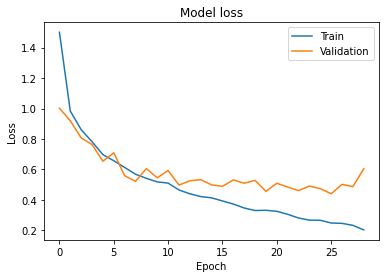

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

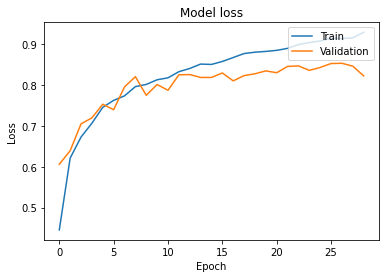

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()